# FH-PS-AOP Challenge: Fetal Head Segmentation and Angle of Progression **Estimation**

Anna Putina,
Universitat Politècnica De Catalunya

## Overview:

This Jupyter notebook presents a solution to the FH-PS-AOP Grand Challenge, focusing on the automatic segmentation of Fetal Head to Pubic Symphysis (FH-PS) structures in transperineal ultrasound images.

## Challenge Description:

The FH-PS-AOP Challenge aims to advance automated techniques for FH-PS segmentation, providing a benchmark dataset for objective method comparison. The task involves creating Docker containers with algorithms that automatically segment FH-PS structures in Test Set.

## Motivation:

- **Development of Automated Techniques:** Encourage the development and application of state-of-the-art automated methods for FH-PS segmentation in transperineal ultrasound images.

- **Benchmark Dataset:** Establish a benchmark dataset for fair and transparent comparisons of different segmentation methods, contributing to advancements in biomedical image analysis.

- **AOP Estimation:** Stimulate the creation of novel, general-purpose methods for the estimation of the Angle of Progression (AOP) in the context of fetal head descent.

## Implementation:

This notebook provides a step-by-step solution to the challenge using the Colab environment. It includes data preprocessing, model development, training, and evaluation on Training Set. The final model can be exported for integration into a Docker container, aligning with the challenge guidelines.

## Imports

Installing the necessary libraries

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 332.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=11666a3960ff43e44764b0bed5becd8615b79d585aa6625d941c041c71e7c5cc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d7be4d6c4ba76830ae8bdb5fae4dc6b4bef30cb70c510d9fa83b3cfd46e6cb35
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=27aaa6bdb3ae00593324c911ad239f941f73d70baa89dfdc37e3d7bf2774af67
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
!pip install torchinfo

In [4]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.9 MB/s eta 0:00:00


In [5]:
#Import libraries
import os
import glob
import random
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Image manipulation
from PIL import Image
import cv2

import SimpleITK as sitk
from skimage.util import montage as montage2d

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from statistics import mean

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss, SoftBCEWithLogitsLoss

In [27]:
import pipreqs # for genearting prequirements.txt  CHECK HOW TO USE IN MY CASE

Secondary functions such as training, calculating metrics, and plotting have been moved to separate files to avoid cluttering the code. To use them, you need to upload them to Colab.

In [ ]:
# From local helper files
from helper_evaluation import compute_accuracy_loss
from helper_metrics import check_metrics
from helper_train import train_model
from helper_plotting import plot_loss_accuracy,  plot_img_mask_pred

## Parameters

In [6]:
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True #?
LOAD_MODEL = False #?

# if encoder needs to be frozen, set below flag = True
freeze_flag = False

In [7]:
DEVICE

device(type='cuda')

## Data loading

To upload the data, first one should upload both folders (one with images and another with masks) to Google Drive, and then mount Google Drive to Colab.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, the names of the directories for images and ground truth are specified.

In [37]:
# Define the base directory where images and ground truth data are stored
base_dir = '/content/drive/My Drive/'

challenge_folder = "Pubic Symphysis-Fetal Head Segmentation and Angle of Progression/"

# Define the subdirectories for images and ground truth
image_folder = challenge_folder + "image_mha/"
gt_folder = challenge_folder + "label_mha/"

In [10]:
# Combine the base directory with subdirectories
image_dir = os.path.join(base_dir, image_folder)
gt_dir = os.path.join(base_dir, gt_folder)

# Get paths to the training and target images
image_paths = sorted([os.path.join(image_dir, fname)
                      for fname in os.listdir(image_dir)
                      if fname.endswith(".mha")])
gt_paths = sorted([os.path.join(gt_dir, fname)
                    for fname in os.listdir(gt_dir)
                    if fname.endswith(".mha")])

# Check if dimensions are equal
print("Number of samples in the image folder:", len(image_paths))
print("Number of samples in the mask folder:", len(gt_paths))

Number of samples in the image folder: 4000
Number of samples in the mask folder: 4000


## Visualisation of an image with its corresponding mask

In [11]:
image = sitk.ReadImage(base_dir + image_folder + '00001.mha')

In [17]:
# Image characteristics
print(image.GetDimension())
print(image.GetWidth())
print(image.GetHeight())
print(image.GetSize())
print(image.GetNumberOfComponentsPerPixel())
print(image.GetDepth())

3
256
256
(256, 256, 3)
1
3


In [18]:
# Conversion between numpy and SimpleITK
np_image = sitk.GetArrayFromImage(image)
print(np_image.shape)

(3, 256, 256)


In [19]:
image_xslice = sitk.GetArrayViewFromImage(image)[0,:,:]
image_yslice = sitk.GetArrayViewFromImage(image)[1,:,:]
image_zslice = sitk.GetArrayViewFromImage(image)[2,:,:]

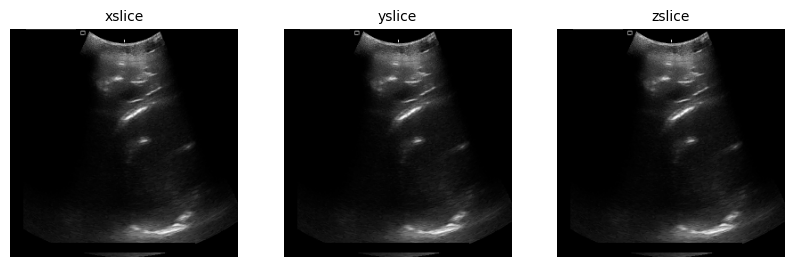

In [22]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(image_xslice, cmap='gray')
plt.title('xslice', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(image_yslice, cmap='gray');
plt.title('yslice', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('zslice', fontsize=10)
plt.imshow(image_zslice, cmap='gray')
plt.axis('off');

In [23]:
mask = sitk.ReadImage(base_dir + gt_folder + '00001.mha')

In [24]:
# Mask characteristics
print(mask.GetDimension())
print(mask.GetWidth())
print(mask.GetHeight())
print(mask.GetSize())
print(mask.GetNumberOfComponentsPerPixel())
print(mask.GetDepth())

2
256
256
(256, 256)
1
0


In [25]:
# Conversion between numpy and SimpleITK
mask_xslice = sitk.GetArrayViewFromImage(mask)

(-0.5, 255.5, 255.5, -0.5)

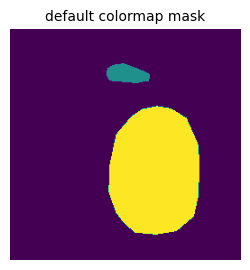

In [26]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,1,1)
plt.imshow(mask_xslice)
plt.title('default colormap mask', fontsize=10)
plt.axis('off')

In [12]:
def image_reader(img_path, isMask):
  img = sitk.ReadImage(img_path)
  np_image = sitk.GetArrayFromImage(img)

  if isMask:
    img_rgb = Image.fromarray(np_image,'L')
    img_array = np_image
  else:
    img_array = np.transpose(np_image, (1,2,0))
    img_rgb = Image.fromarray(img_array,'RGB')

  return img_rgb, img_array

In [30]:
index = 100

In [31]:
image, img_np = image_reader(base_dir + image_folder + f'{index:05d}.mha', False)
mask, mask_np = image_reader(base_dir + gt_folder + f'{index:05d}.mha', True)

(-0.5, 255.5, 255.5, -0.5)

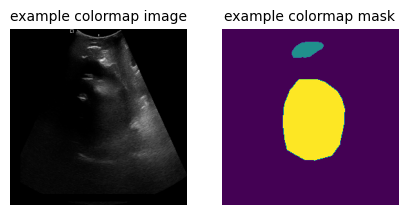

In [32]:
# Showing image and mask in the same plot
fig = plt.figure(figsize=(5,5))

fig.add_subplot(1,2,1)
plt.imshow(img_np)
plt.title('example colormap image', fontsize=10)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(mask_np);
plt.title('example colormap mask', fontsize=10)
plt.axis('off')

In [39]:
# Isolating FH, PS, and background in the mask
mask_tensor = torch.tensor(mask_np)
mask_dict = {0:'background', 1: 'PS', 2:'FH'}
mask_np = mask_tensor.type(torch.LongTensor)
main_mask = F.one_hot(mask_np, len(mask_dict))
main_mask = np.asarray(main_mask)
main_mask.shape

(256, 256, 3)

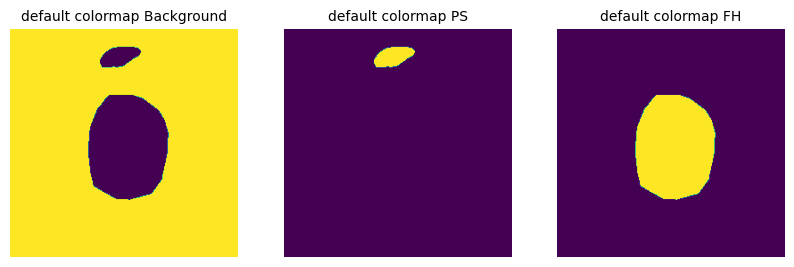

In [41]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(main_mask[:,:,0])
plt.title('default colormap Background', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(main_mask[:,:,1]);
plt.title('default colormap PS', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('default colormap FH', fontsize=10)
plt.imshow(main_mask[:,:,2])
plt.axis('off');

## Creating datasets and dataloaders

In [13]:
percentage_test = 0.15
percentage_validation = 0.15

# Set your random seed for reproducibility
random_seed = 142

# Split your data into training, validation, and test sets
image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, gt_paths, test_size=percentage_test, random_state=random_seed)
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(image_paths_trainval, mask_paths_trainval, test_size=percentage_validation, random_state=random_seed)

In [14]:
CLASSES = ['background','FH','PS']

Image and mask transform operations

In [15]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CoarseDropout(
            max_holes = 4, # Maximum number of regions to zero out. (default: 8)
            max_height = 4, # Maximum height of the hole. (default: 8)
            max_width = 4, # Maximum width of the hole. (default: 8)
            min_holes=None, # Minimum number of regions to zero out. (default: None, which equals max_holes)
            min_height=None, # Minimum height of the hole. (default: None, which equals max_height)
            min_width=None, # Minimum width of the hole. (default: None, which equals max_width)
            fill_value=0, # value for dropped pixels.
            mask_fill_value=None, # fill value for dropped pixels in mask.
            always_apply=False,
            p=0.5
            ),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [16]:
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [17]:
class HeadSymphysisDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        _, img = image_reader(img_name, False)
        _, mask = image_reader(mask_name, True)

        if self.transform:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]

        mask = mask.type(torch.LongTensor)
        mask_onehot = F.one_hot(mask, len(CLASSES))
        mask_stack = torch.stack((mask_onehot[:,:,0], mask_onehot[:,:,1], mask_onehot[:,:,2]))
        mask_stack = mask_stack.type(torch.IntTensor)

        return img, mask_stack

In [18]:
train_dataset = HeadSymphysisDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = HeadSymphysisDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = HeadSymphysisDataset(image_paths_test, mask_paths_test, transform = val_transform)

In [19]:
len(test_dataset)

600

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)

In [21]:
print(len(train_dataloader))
print(len(val_dataloader))

289
51


## Model

In [22]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_model(model, filename="best_unet_model.pth"):
    print("=> Saving model")
    torch.save(model, filename)
    print('Model saved!')

In [23]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [24]:
# resnet18,mit_b0,densenet121,timm-resnest14d,timm-resnest50d
ENCODER = 'mit_b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background','head','pubic symphysis']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

AUX_PARAMS=dict(
    pooling='max',           # one of 'avg', 'max'
    dropout=0.2,            # try to avoid overfitting
    activation='softmax',  # activation function, default is None
    #activation='sigmoid',
    classes=len(CLASSES),    # define number of output labels
)

In [25]:
# create segmentation model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /root/.cache/torch/hub/checkpoints/mit_b0.pth
100%|██████████| 13.7M/13.7M [00:01<00:00, 13.3MB/s]


In [26]:
model = unet_model

if freeze_flag:
  model_name = f'unet_frozen_{ENCODER}'
else:
  model_name = f'unet_{ENCODER}'

print(model_name)

unet_mit_b0


In [27]:
model.classification_head = None

In [28]:
summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─MixVisionTransformerEncoder: 1-1            --
│    └─OverlapPatchEmbed: 2-1                 --
│    │    └─Conv2d: 3-1                       4,736
│    │    └─LayerNorm: 3-2                    64
│    └─OverlapPatchEmbed: 2-2                 --
│    │    └─Conv2d: 3-3                       18,496
│    │    └─LayerNorm: 3-4                    128
│    └─OverlapPatchEmbed: 2-3                 --
│    │    └─Conv2d: 3-5                       92,320
│    │    └─LayerNorm: 3-6                    320
│    └─OverlapPatchEmbed: 2-4                 --
│    │    └─Conv2d: 3-7                       368,896
│    │    └─LayerNorm: 3-8                    512
│    └─ModuleList: 2-5                        --
│    │    └─Block: 3-9                        79,616
│    │    └─Block: 3-10                       79,616
│    └─LayerNorm: 2-6                         64
│    └─ModuleList: 2-7               

In [29]:
model = model.to(DEVICE)

In [30]:
def get_dice(tp, fp, fn, tn):

  tp = torch.sum(tp)
  fp = torch.sum(fp)
  fn = torch.sum(fn)
  tn = torch.sum(tn)

  dice_value = 2*tp / (2*tp + fp + fn)
  dice_loss = 1 - dice_value

  return dice_value

In [31]:
#loss_fn = smp.utils.losses.DiceLoss()
#loss_fn = smp.utils.losses.JaccardLoss()
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCEWithLogitsLoss()
loss_jaccard = JaccardLoss(mode='multilabel', from_logits=False)
loss_bce = SoftBCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [32]:
def check_accuracy(loader, model, pix_acc, num_classes, device="cuda", is_train=True):
  accuracy_list = []
  iou_list = []
  dice_scores = []
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = model(x)
      preds = (preds > 0.5).int()
      tp, fp, fn, tn = smp.metrics.get_stats(preds, y,
                                             threshold=0.5,
                                             mode='multilabel')

      accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
      iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
      dice_score = get_dice(tp, fp, fn, tn)

      accuracy_list.append(accuracy)
      iou_list.append(iou_score)
      dice_scores.append(dice_score)

  #p_acc = mean(accuracy_list)
  p_acc = torch.mean(torch.stack(accuracy_list)).item()
  print(f"Got pixel accuracy: {p_acc:.6f}")
  pix_acc.append(p_acc)

  #mean_iou = mean(iou_list)
  mean_iou = torch.mean(torch.stack(iou_list)).item()
  print(f"mean IoU score: {mean_iou:.7f}")

  #mean_dice = mean(dice_scores)
  mean_dice = torch.mean(torch.stack(dice_scores)).item()
  print(f"mean Dice score: {mean_dice:.7f}")

  #metrics_out.append(pix_acc, mean_iou, mean_dice)

  if is_train:
    model.train()

  return [pix_acc, mean_iou, mean_dice] #metrics_out

In [33]:
def train_fn(loader, model, optimizer, loss_fn_1, loss_fn_2, num_classes, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    #targets = targets.float().unsqueeze(1).to(device=DEVICE)
    targets = targets.to(device=DEVICE)
    model.train()

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      #predictions = (predictions > 0.5).int()
      #loss = loss_fn.forward(predictions[0], targets)

      #loss = loss_fn(predictions, targets.float())

      loss = loss_fn_1.forward(predictions, targets) + loss_fn_2.forward(predictions, targets.float())

      #preds = (predictions > 0.5).int()
      #tp, fp, fn, tn = smp.metrics.get_stats(preds, targets, threshold=0.5, mode='multilabel')

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return loss.item()

In [34]:
import multiprocessing as mp

In [35]:
num_class = len(CLASSES)

best_loss = 1.0

pix_acc = []

for epoch in range(NUM_EPOCHS):
  #
  #train_loader
  #loss_jaccard = JaccardLoss(mode='multilabel', from_logits=False)
  #loss_bce = SoftBCEWithLogitsLoss()
  #
  current_loss = train_fn(train_dataloader, model, optimizer, loss_jaccard, loss_bce, num_class, scaler)

  # check accuracy
  #val_loader
  metric_results = check_accuracy(val_dataloader, model, pix_acc, num_class, device=DEVICE)

  # print some examples to a folder
  #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.982432
mean IoU score: 0.9486713
mean Dice score: 0.9736443


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.987853
mean IoU score: 0.9642319
mean Dice score: 0.9817795


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.988625
mean IoU score: 0.9664733
mean Dice score: 0.9829367


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.989861
mean IoU score: 0.9700580
mean Dice score: 0.9847919


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.990457
mean IoU score: 0.9717883
mean Dice score: 0.9856859


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.990730
mean IoU score: 0.9725842
mean Dice score: 0.9860954


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.991096
mean IoU score: 0.9736509
mean Dice score: 0.9866440


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.991374
mean IoU score: 0.9744651
mean Dice score: 0.9870616


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992208
mean IoU score: 0.9769063
mean Dice score: 0.9883126


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992191
mean IoU score: 0.9768554
mean Dice score: 0.9882861


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992168
mean IoU score: 0.9767893
mean Dice score: 0.9882526


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992605
mean IoU score: 0.9780666
mean Dice score: 0.9889067


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992199
mean IoU score: 0.9768766
mean Dice score: 0.9882985


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992821
mean IoU score: 0.9787032
mean Dice score: 0.9892312


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992493
mean IoU score: 0.9777400
mean Dice score: 0.9887394


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992697
mean IoU score: 0.9783364
mean Dice score: 0.9890450


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992877
mean IoU score: 0.9788672
mean Dice score: 0.9893150


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992952
mean IoU score: 0.9790879
mean Dice score: 0.9894286


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.993056
mean IoU score: 0.9793905
mean Dice score: 0.9895834


  0%|          | 0/289 [00:00<?, ?it/s]

Got pixel accuracy: 0.992961
mean IoU score: 0.9791130
mean Dice score: 0.9894413


In [38]:
# set path to save
save_flag = True
save_path = base_dir + challenge_folder + f'/Saved Models/'
checkpoint_name = save_path + f"{model_name}_model_2808.pt"
checkpoint_name

'/content/drive/My Drive/Pubic Symphysis-Fetal Head Segmentation and Angle of Progression//Saved Models/unet_mit_b0_model_2808.pt'

In [39]:
def save_checkpoint(state, trg_path):
  print("=> Saving checkpoint")
  torch.save(state, trg_path)

In [40]:
save_flag = True

In [41]:
if save_flag:
  '''
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  '''
  save_checkpoint(model, checkpoint_name)
  print(f"{checkpoint_name}")

=> Saving checkpoint
/content/drive/My Drive/Pubic Symphysis-Fetal Head Segmentation and Angle of Progression//Saved Models/unet_mit_b0_model_2808.pt


## Evaluating model